
[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


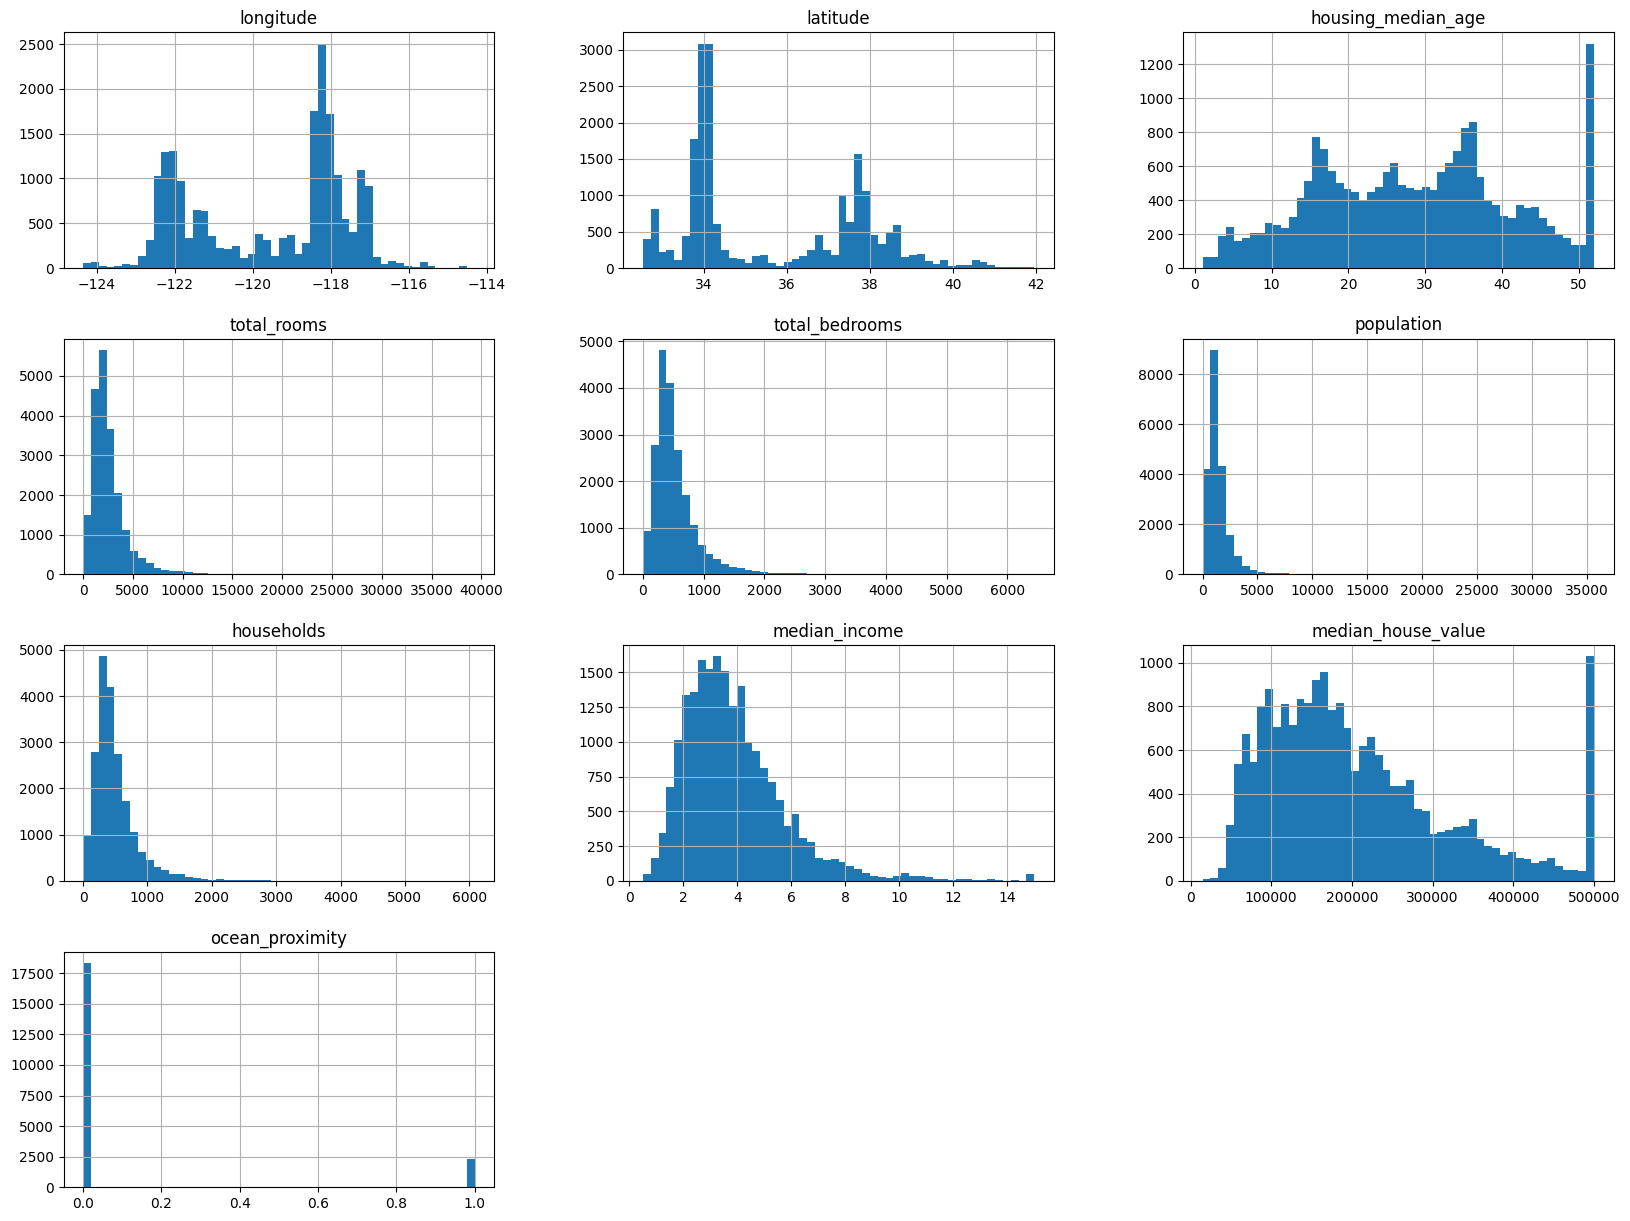

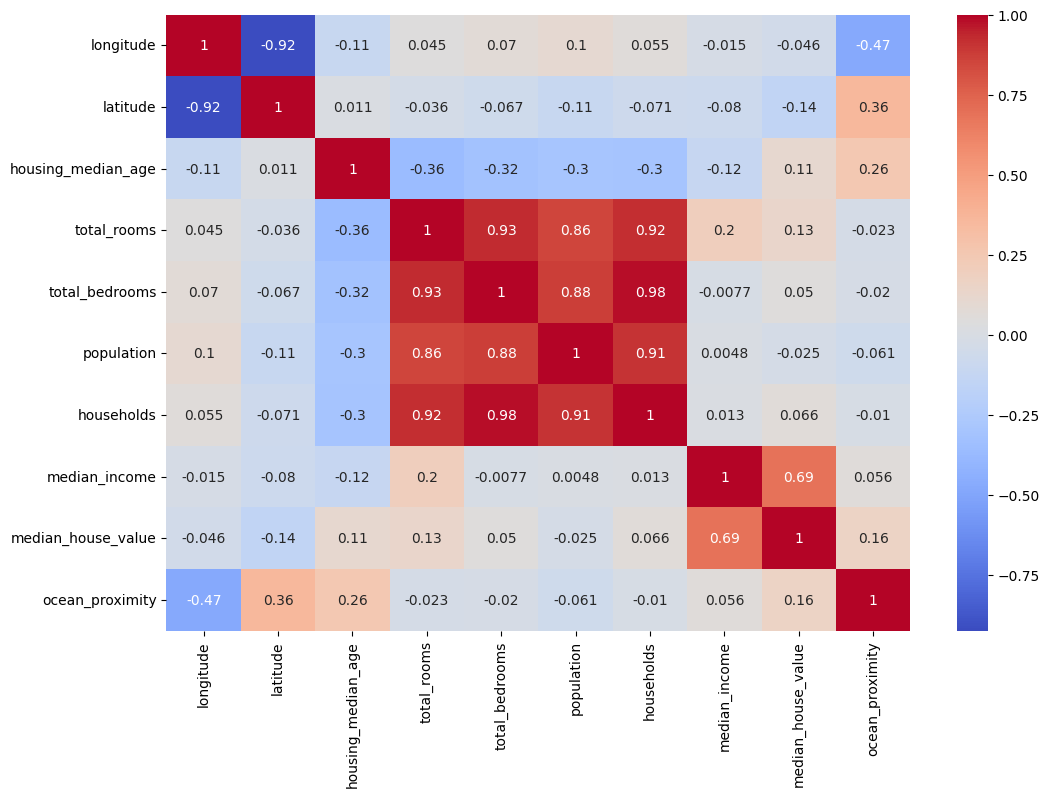

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  int32  
dtypes: float64(9), int32(1)
m

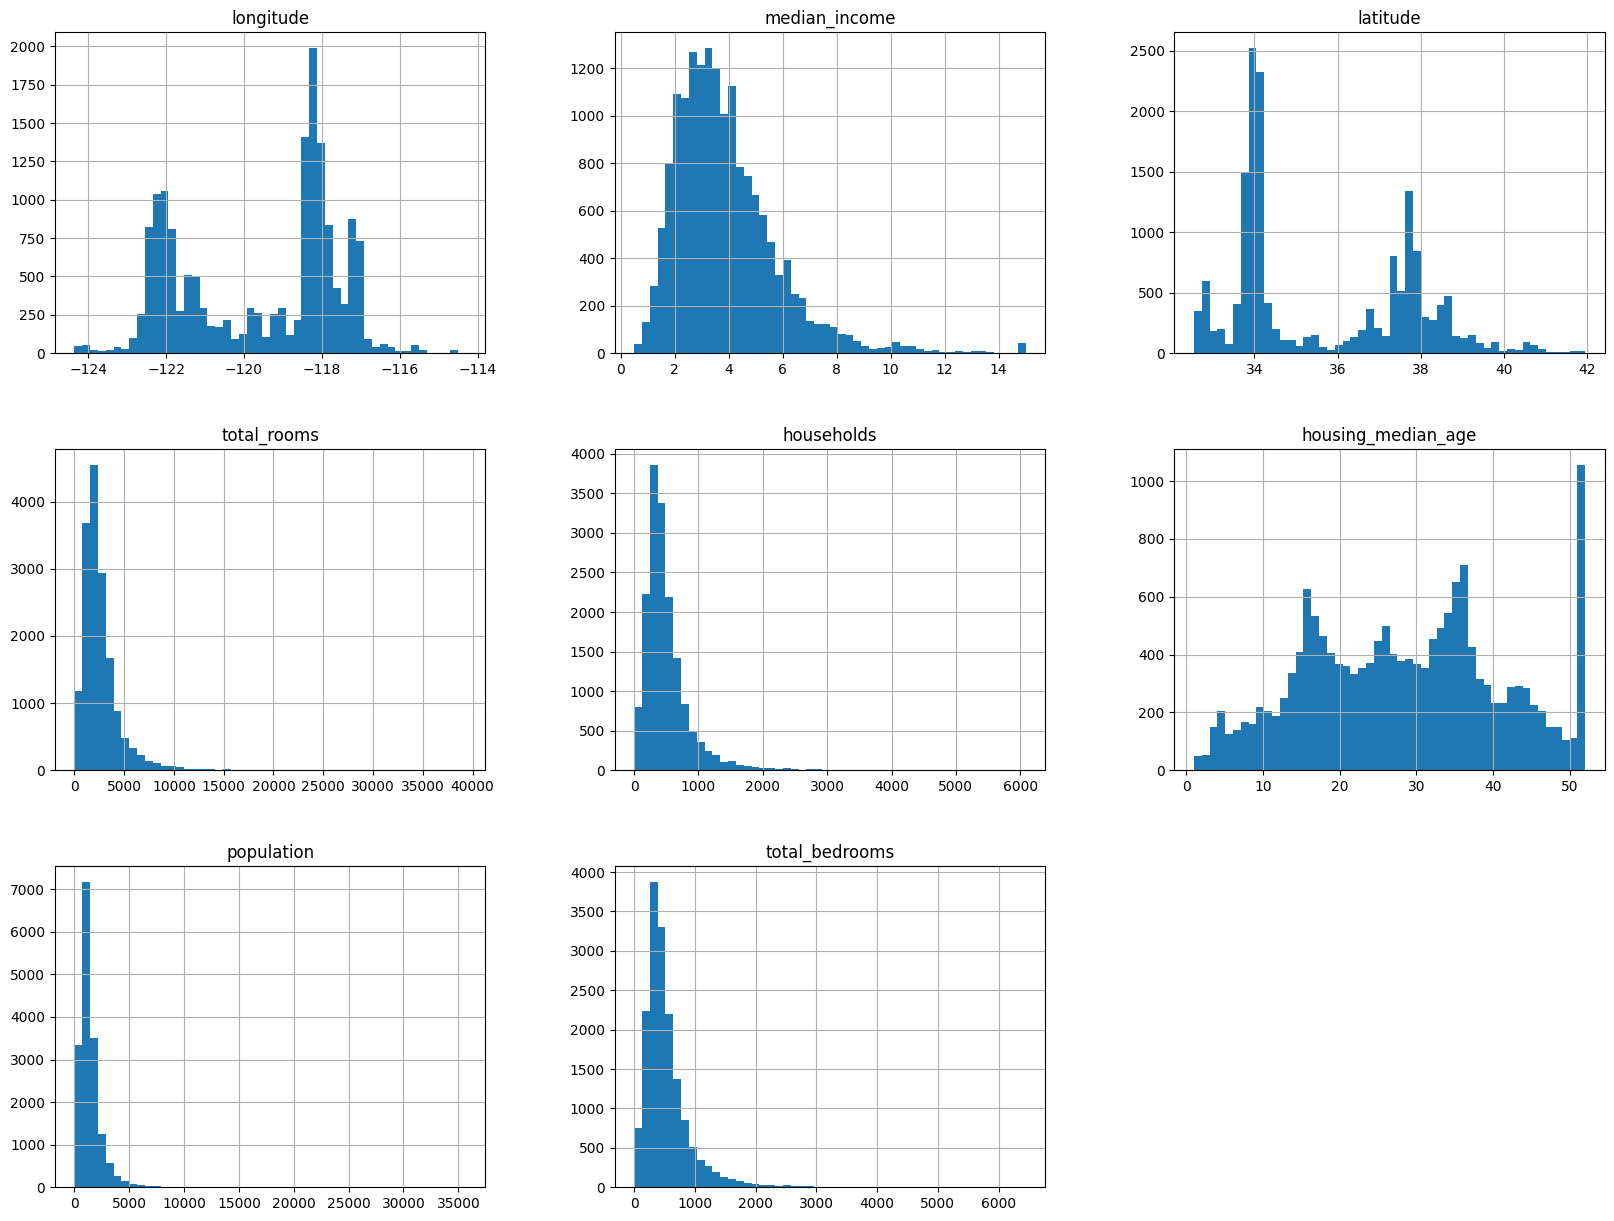

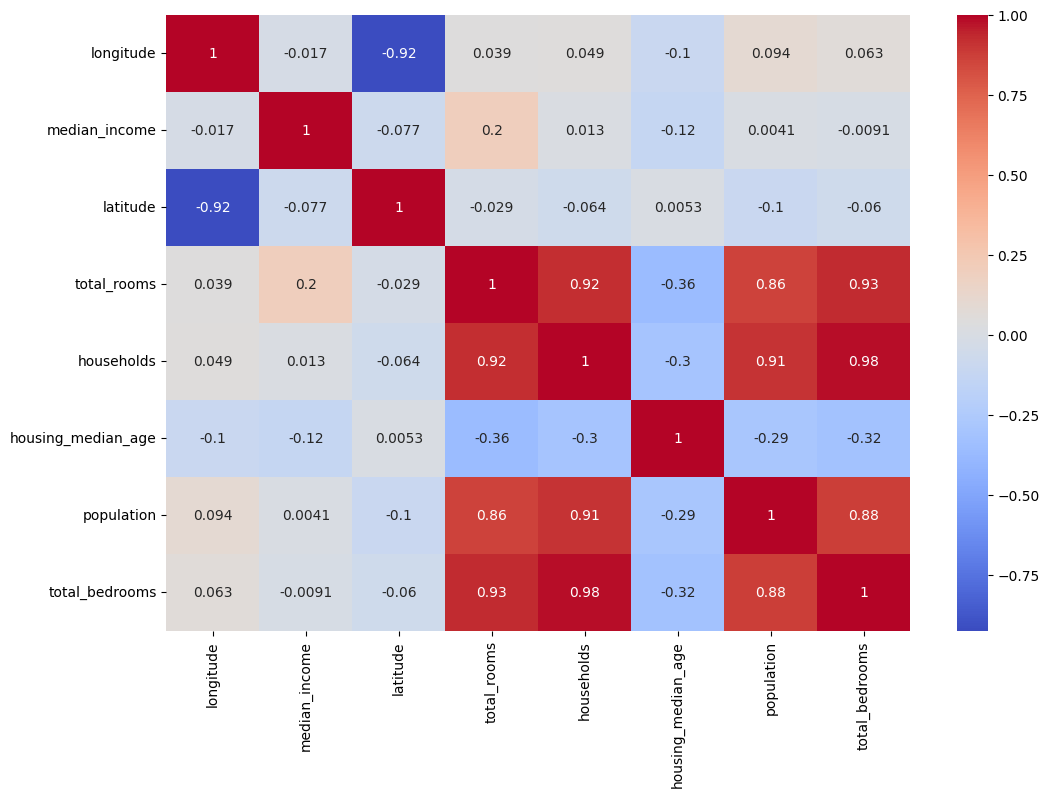

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  ocean_proximity  \
20046      1392.0       359.0         1.6812                0   
3024       1565.0       584.0         2.5313                0   
15663      1310.0       963.0         3.4801                1   
20484      1705.0       495.0         5.7376                0   
9814       1063.0       428.0         3.7250                0   

       median_house_value  
20046             47700.0  
3024              45800.0  
15663            500001.0  
20484            21860

In [14]:
!pip install pandas numpy matplotlib seaborn scikit-learn optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import optuna
import joblib
from sklearn.feature_selection import mutual_info_regression

# Carga el conjunto de datos
url = 'housing.csv'
data = pd.read_csv(url)

# Transformar 'ocean_proximity' en valores numéricos (0 o 1)
data["ocean_proximity"] = (data["ocean_proximity"] == "NEAR BAY").astype(int)

# Análisis Exploratorio de Datos (EDA)
data.hist(bins=50, figsize=(20, 15))
plt.show()

# Correlaciones incluyendo 'ocean_proximity' transformada
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


# Valores Faltantes
missing_values = data.isnull().sum()
print(missing_values)

# Tipos de Datos
data.info()

# Ingeniería de Características con Mutual Information Gain
def calculate_mutual_information(data, target):
    mutual_info = mutual_info_regression(data, target)
    mutual_info = pd.Series(mutual_info, index=data.columns)
    mutual_info = mutual_info.sort_values(ascending=False)
    return mutual_info

# Ingeniería/Selección de Características + Limpieza de Datos
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Seleccionar las top N características basadas en Mutual Information Gain
top_features = 8  # Puedes ajustar este número según sea necesario
target_column = "median_house_value"
selected_columns = data.columns[data.columns != target_column]

# Imputar datos
imputer = SimpleImputer(strategy='mean')
train_data_imputed = imputer.fit_transform(train_data[selected_columns])
test_data_imputed = imputer.transform(test_data[selected_columns])

# Escalar datos
scaler = StandardScaler()
train_data_scaled_imputed = scaler.fit_transform(train_data_imputed)
test_data_scaled_imputed = scaler.transform(test_data_imputed)


# Calcular la ganancia de información mutua
selected_features = calculate_mutual_information(pd.DataFrame(train_data_scaled_imputed, columns=selected_columns), train_data[target_column]).head(top_features).index

# Análisis Exploratorio de Datos (EDA) con características seleccionadas
train_data[selected_features].hist(bins=50, figsize=(20, 15))
plt.show()

# Correlaciones con características seleccionadas
correlation_matrix = train_data[selected_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Resto del código...

# Guardar datos preprocesados (puedes almacenarlos en un Feature Store)
np.save('X_train.npy', train_data_scaled_imputed[:, np.isin(selected_columns, selected_features)])
np.save('X_test.npy', test_data_scaled_imputed[:, np.isin(selected_columns, selected_features)])
np.save('y_train.npy', train_data[target_column].to_numpy())
np.save('y_test.npy', test_data[target_column].to_numpy())  # Agregar esta línea
selected_columns = list(selected_columns)
selected_columns.append(target_column)
np.save('test_data.npy', test_data[selected_columns].to_numpy())

np.save('test_data_index.npy', test_data.index.to_numpy())
print(test_data[selected_columns].head())
